## 设置随机种子，保证实验可复现

In [83]:
import random
import torch


# -------------------------------
# 1. 设置随机种子，保证实验可复现
# -------------------------------
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(42)

# 创建保存中间结果的目录
import os

os.makedirs("intermediates", exist_ok=True)

## 参数配置

In [84]:
config = {
    "data_dir": "/data/Workspace/CIC-IoTDataset2023/bin-class",  # 数据集目录
    "num_classes": 2,  # 类别数
    "batch_size": 128,  # 批量大小（根据显存实际情况调整）
    "lr": 1e-4,  # 学习率
    "epochs": 100,  # 总训练轮数
    "model_name": "Conv2Former",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

## 数据增强设置

In [85]:
from torchvision import transforms

train_transform = transforms.Compose([
    # transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

valid_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

## 数据集与 DataLoader

In [86]:
from MyDataset import CustomDataset
from torch.utils.data import DataLoader

train_dataset = CustomDataset(os.path.join(config["data_dir"], "train"), transform=train_transform)
valid_dataset = CustomDataset(os.path.join(config["data_dir"], "valid"), transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config["batch_size"], shuffle=False)

## 模型定义

In [87]:
# 这里 dims 与 depths 可根据实验调节，本示例给出较轻量配置
from deepseek import Conv2Former

model = Conv2Former(dims=[96, 192, 384, 768], depths=[3, 3, 9, 3], num_classes=config["num_classes"])
model = model.to(config["device"])

## 损失函数、优化器与学习率调度器

In [88]:
from torch import nn, optim
from torch.cuda.amp import GradScaler

# 这里采用了类别权重，适用于类别不平衡场景
class_weights = torch.tensor([7.0, 1.0])
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights.to(config["device"]))

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, epochs=config["epochs"], max_lr=1e-3,
                                          total_steps=config["epochs"] * len(train_loader),
                                          pct_start=0.1, anneal_strategy="cos")
# 如果需要可尝试 OneCycleLR 或 Warmup 策略

best_val_acc = 0.0
scaler = GradScaler()  # 用于混合精度训练

## 训练与验证函数

In [96]:
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast


def train(epoch_num: int):
    model.train()
    total_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Train {epoch_num:>3}/{config['epochs']}", leave=True, unit=" batch")
    for images, labels in train_bar:
        images = images.to(config["device"])
        labels = labels.to(config["device"])
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        # 梯度裁剪，防止梯度爆炸
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * images.size(0)
        train_bar.set_postfix(loss=loss.item())
    return total_loss / len(train_dataset)


def validate(epoch_num: int):
    model.eval()
    correct = 0
    total = 0
    all_predicts = []
    all_labels = []
    valid_bar = tqdm(valid_loader, desc=f"Valid {epoch_num:>3}/{config['epochs']}", leave=True, unit=" batch")
    with torch.no_grad():
        for images, labels in valid_bar:
            images = images.to(config["device"])
            labels = labels.to(config["device"])
            # outputs = model(images)
            # TTA: 原图 + 水平翻转
            outputs = model(images) + model(torch.flip(images, dims=[-1]))
            _, predicts = torch.max(outputs, 1)
            correct += (predicts == labels).sum().item()
            total += labels.size(0)
            all_predicts.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            valid_bar.set_postfix(batch_acc=(predicts == labels).float().mean().item())
    valid_acc = correct / total
    # from sklearn.metrics import classification_report
    # print(classification_report(all_labels, all_predicts, zero_division=0, digits=4))
    return valid_acc

## 训练循环

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/conv2former_train')
train_losses = []
valid_accs = []
best_model = None

for epoch in range(config["epochs"]):
    train_loss = train(epoch_num=epoch + 1)
    train_losses.append(train_loss)
    writer.add_scalar('Loss/train', train_loss, epoch)

    valid_acc = validate(epoch_num=epoch + 1)
    valid_accs.append(valid_acc)
    writer.add_scalar('Accuracy/val', valid_acc, epoch)

    scheduler.step()

    # 保存最佳模型
    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        best_model = model

    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Acc: {valid_acc:.4f}")

writer.close()

from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H_%M")
torch.save(best_model.state_dict(), f"intermediates/best_model_{timestamp}.pth")


Train   1/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid   1/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 1, Train Loss: 0.0586, Val Acc: 0.9933


Train   2/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid   2/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 2, Train Loss: 0.0587, Val Acc: 0.9928


Train   3/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid   3/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 3, Train Loss: 0.0586, Val Acc: 0.9924


Train   4/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid   4/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 4, Train Loss: 0.0586, Val Acc: 0.9929


Train   5/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid   5/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 5, Train Loss: 0.0585, Val Acc: 0.9933


Train   6/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid   6/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 6, Train Loss: 0.0586, Val Acc: 0.9935


Train   7/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid   7/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 7, Train Loss: 0.0586, Val Acc: 0.9941


Train   8/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid   8/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 8, Train Loss: 0.0586, Val Acc: 0.9937


Train   9/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid   9/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 9, Train Loss: 0.0586, Val Acc: 0.9929


Train  10/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid  10/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 10, Train Loss: 0.0586, Val Acc: 0.9933


Train  11/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid  11/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 11, Train Loss: 0.0586, Val Acc: 0.9913


Train  12/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid  12/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 12, Train Loss: 0.0585, Val Acc: 0.9936


Train  13/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid  13/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 13, Train Loss: 0.0587, Val Acc: 0.9928


Train  14/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid  14/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 14, Train Loss: 0.0585, Val Acc: 0.9929


Train  15/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid  15/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 15, Train Loss: 0.0585, Val Acc: 0.9935


Train  16/100:   0%|          | 0/657 [00:00<?, ? batch/s]

Valid  16/100:   0%|          | 0/147 [00:00<?, ? batch/s]

Epoch: 16, Train Loss: 0.0585, Val Acc: 0.9932


Train  17/100:   0%|          | 0/657 [00:00<?, ? batch/s]

In [91]:
valid_accs

[0.9242109745063601,
 0.9602426951939965,
 0.9665229655649582,
 0.9826494225344616,
 0.9671084144978445,
 0.9828090904252488,
 0.9881845760817499,
 0.9867475650646655,
 0.9885039118633243,
 0.9792963968279312,
 0.9901005907711959,
 0.9836074298791846,
 0.992176273351429,
 0.9886635797541115,
 0.9918037149395923,
 0.9906328170738198,
 0.9917504923093299,
 0.9916440470488052,
 0.9914311565277556,
 0.992176273351429,
 0.9914311565277556,
 0.9902070360317207,
 0.9928149449145777,
 0.988610357123849,
 0.991218266006706,
 0.9923359412422161,
 0.9924956091330034,
 0.9916972696790676,
 0.9880249081909628,
 0.9922294959816914,
 0.9919101602001171,
 0.9914311565277556,
 0.991218266006706,
 0.9920698280909043,
 0.9916972696790676,
 0.9922294959816914,
 0.9920698280909043,
 0.9926552770237905,
 0.991484379158018,
 0.9888232476448986,
 0.9915908244185427,
 0.9906328170738198,
 0.9919633828303794,
 0.991484379158018,
 0.9904199265527702,
 0.9922827186119538,
 0.9858427803502049,
 0.9931875033264144,

## 保存数据

In [92]:
import pickle
from datetime import datetime

training_data = {'train_losses': train_losses, 'valid_accs': valid_accs}

# 获取当前时间，格式为 'YYYYMMDD_HH_MM'
timestamp = datetime.now().strftime("%Y%m%d_%H_%M")

# 构建文件名
file_name = f"intermediates/training_data_{timestamp}.pkl"

# 保存数据到文件
with open(file_name, "wb") as f:
    pickle.dump(training_data, f)


## 加载数据并绘图

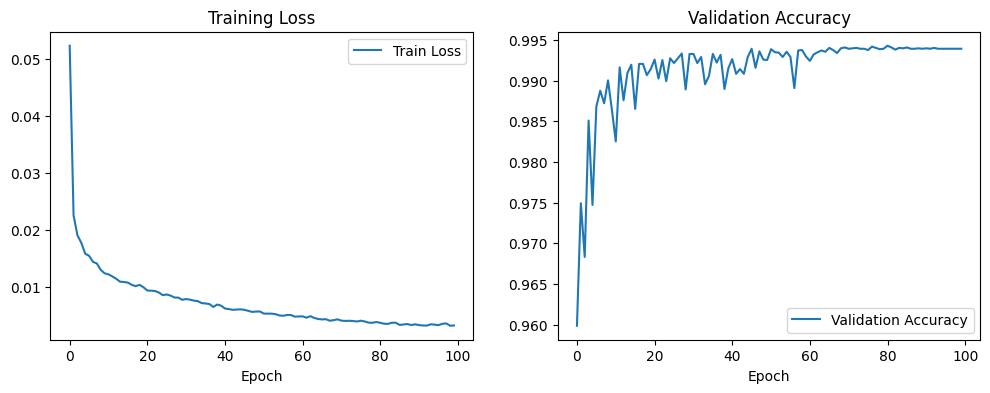

In [93]:
import pickle
import matplotlib.pyplot as plt

# 构建文件名
file_name = "intermediates/training_data_20250213_01_13.pkl"

# 加载保存的数据
with open(file_name, "rb") as f:
    training_data = pickle.load(f)

train_losses = training_data['train_losses']
valid_accs = training_data['valid_accs']

# 绘制图形
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valid_accs, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.show()


In [94]:
# train_losses
valid_accs

[0.9598701367821598,
 0.9749321411464155,
 0.9683325349938794,
 0.9850976635265315,
 0.9747192506253659,
 0.9868540103251903,
 0.9887700250146362,
 0.987226568737027,
 0.9900473681409335,
 0.9864282292830912,
 0.9825429772739369,
 0.9916440470488052,
 0.9875991271488637,
 0.9909521528553941,
 0.9919633828303794,
 0.986534674543616,
 0.9920698280909043,
 0.9920698280909043,
 0.9906860397040822,
 0.9914311565277556,
 0.9926020543935281,
 0.9902602586619831,
 0.9925488317632657,
 0.9899409228804088,
 0.9927617222843153,
 0.992176273351429,
 0.9927617222843153,
 0.9933471712172015,
 0.9889296929054234,
 0.9932939485869392,
 0.9932939485869392,
 0.992176273351429,
 0.9929213901751025,
 0.989568364468572,
 0.9905795944435574,
 0.9932939485869392,
 0.9922294959816914,
 0.9931875033264144,
 0.9889829155356857,
 0.9915376017882804,
 0.9926552770237905,
 0.9908457075948693,
 0.9914311565277556,
 0.9908457075948693,
 0.9929213901751025,
 0.9939326201500878,
 0.9915908244185427,
 0.993613284368513

## 结果可视化

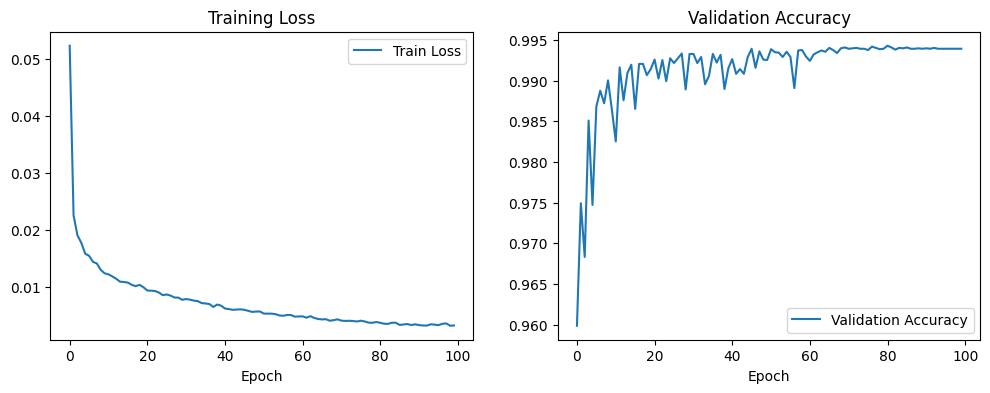

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valid_accs, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.savefig("intermediates/training_curve.png")
plt.show()